<a href="https://colab.research.google.com/github/philxhuang/udacity-projects/blob/master/5_InferenceValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference and Validation Techniques

## Basics for Showing Loss & Performance

In [0]:
import torch
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

In [0]:
def view_classify(img, ps, version="MNIST"):
   ''' Function for viewing an image and it's predicted classes.
   '''
   ps = ps.data.numpy().squeeze()

   fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
   ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
   ax1.axis('off')
   ax2.barh(np.arange(10), ps)
   ax2.set_aspect(0.1)
   ax2.set_yticks(np.arange(10))
   if version == "MNIST":
       ax2.set_yticklabels(np.arange(10))
   elif version == "Fashion":
       ax2.set_yticklabels(['T-shirt/top',
                           'Trouser',
                           'Pullover',
                           'Dress',
                           'Coat',
                           'Sandal',
                           'Shirt',
                           'Sneaker',
                           'Bag',
                           'Ankle Boot'], size='small');
   ax2.set_title('Class Probability')
   ax2.set_xlim(0, 1.1)

   plt.tight_layout()

In [0]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [0]:
from torch import nn, optim
import torch.nn.functional as F

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)
    
  def forward(self, x):
    # faltten the tensors in the trainset first
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.fc4(x), dim=1)
    
    return x

In [0]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

Here we can see our test set is the same size as the trainset, only that we are not putting it through the training process with gradient descent that would change the wights of the model.

After passing through a test batch, we should see that the untrained model doesn't perform well.

In [7]:
images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


Now we use topk to find the largest prediction in the second column, which are labels.

In [8]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_p.shape)
print(top_class.shape)
print(top_class[:10,:]) # only looking at the first 10 predictions

torch.Size([64, 1])
torch.Size([64, 1])
tensor([[5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5]])


The we can find how many correct predictions are there. This should be low now because our model is untrained.

In [9]:
print(labels.view(*top_class.shape).shape)
equals = (top_class == labels.view(*top_class.shape))
print(equals[:10,:])

torch.Size([64, 1])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.uint8)


In [10]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 7.8125%


Now let's start training. Be careful reading the code. Make sure you understand where the training loss and testing loss are.

In [11]:
epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader: # trainset
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader: # testset
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.512..  Test Loss: 0.472..  Test Accuracy: 0.830
Epoch: 2/30..  Training Loss: 0.390..  Test Loss: 0.423..  Test Accuracy: 0.844
Epoch: 3/30..  Training Loss: 0.351..  Test Loss: 0.383..  Test Accuracy: 0.861
Epoch: 4/30..  Training Loss: 0.328..  Test Loss: 0.395..  Test Accuracy: 0.860
Epoch: 5/30..  Training Loss: 0.317..  Test Loss: 0.373..  Test Accuracy: 0.870
Epoch: 6/30..  Training Loss: 0.299..  Test Loss: 0.386..  Test Accuracy: 0.866
Epoch: 7/30..  Training Loss: 0.288..  Test Loss: 0.377..  Test Accuracy: 0.867
Epoch: 8/30..  Training Loss: 0.280..  Test Loss: 0.374..  Test Accuracy: 0.866
Epoch: 9/30..  Training Loss: 0.277..  Test Loss: 0.382..  Test Accuracy: 0.867
Epoch: 10/30..  Training Loss: 0.268..  Test Loss: 0.372..  Test Accuracy: 0.876
Epoch: 11/30..  Training Loss: 0.261..  Test Loss: 0.371..  Test Accuracy: 0.876
Epoch: 12/30..  Training Loss: 0.256..  Test Loss: 0.359..  Test Accuracy: 0.875
Epoch: 13/30..  Training Loss: 0.242.

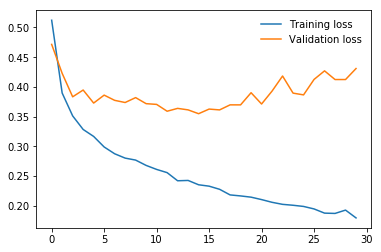

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

The regular model starts to over fit around 15 epoches, as validation loss starts to increase visibly. At this point is where the test loss starts to increase back up too.

## Solution: Rebuilding NN with Dropout Methods

Now we extrat the Dropout model from torch.nn. Apply it to all linear layers except the last one. Wrap them around the linear layers after applying ReLU to turn them off. The probability of a node/neuron getting turned off is 0.2=20%.

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

Here we turn off dropouts by model.eval() so model is in evaluation mode. After evaluation we turn it on by model.train().

In [14]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.603..  Test Loss: 0.460..  Test Accuracy: 0.833
Epoch: 2/30..  Training Loss: 0.485..  Test Loss: 0.467..  Test Accuracy: 0.829
Epoch: 3/30..  Training Loss: 0.454..  Test Loss: 0.433..  Test Accuracy: 0.842
Epoch: 4/30..  Training Loss: 0.432..  Test Loss: 0.434..  Test Accuracy: 0.848
Epoch: 5/30..  Training Loss: 0.418..  Test Loss: 0.447..  Test Accuracy: 0.850
Epoch: 6/30..  Training Loss: 0.411..  Test Loss: 0.381..  Test Accuracy: 0.863
Epoch: 7/30..  Training Loss: 0.400..  Test Loss: 0.407..  Test Accuracy: 0.856
Epoch: 8/30..  Training Loss: 0.401..  Test Loss: 0.394..  Test Accuracy: 0.859
Epoch: 9/30..  Training Loss: 0.397..  Test Loss: 0.400..  Test Accuracy: 0.861
Epoch: 10/30..  Training Loss: 0.389..  Test Loss: 0.387..  Test Accuracy: 0.865
Epoch: 11/30..  Training Loss: 0.389..  Test Loss: 0.398..  Test Accuracy: 0.860
Epoch: 12/30..  Training Loss: 0.382..  Test Loss: 0.412..  Test Accuracy: 0.850
Epoch: 13/30..  Training Loss: 0.379.

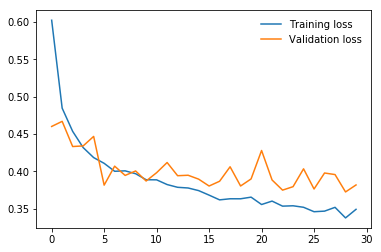

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

Now from the graph, we can see the test loss goes down as train loss goes down. This is desirable.

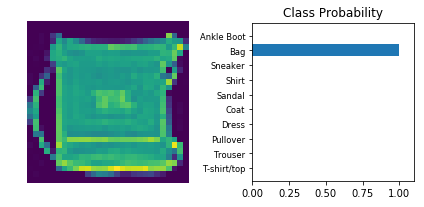

In [16]:
# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

view_classify(img.view(1, 28, 28), ps, version='Fashion')

Now our model actually has pretty high accuracy without overfitting.